In [1]:
from google.colab import drive


In [2]:

drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
# root_path = 'gdrive/My Drive/Colab Notebooks/Classif_img_CNN/datas/'
root_path = 'gdrive/My Drive/Simplon/'

unset HISTFILE; export PS1="root@d16f66685eda-9833a5a52b454206997ef9ddc962b6d2: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@d16f66685eda-9833a5a52b454206997ef9ddc962b6d2: umount -f /content/gdrive || umount /content/gdrive; pkill -9 -x drive
umount: /content/gdrive: no mount point specified.
umount: /content/gdrive: no mount point specified.
root@d16f66685eda-9833a5a52b454206997ef9ddc962b6d2: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@d16f66685eda-9833a5a52b454206997ef9ddc962b6d2: ( while `sleep 0.5`; do if [[ -d "/content/gdrive" && "$(ls -A /content/gdrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 89
root@d16f66685eda-9833a5a52b454206997ef9ddc962b6d2: cat /tmp/tmpitdk_v0k/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instan

In [3]:
file = ''.join(root_path+'AnimalFace.zip')
file

'gdrive/My Drive/Simplon/AnimalFace.zip'

In [4]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [5]:
!rm '/content/datas/Image/DogHead/dog000590a.jpg'

In [6]:
path = '/content/datas/Image'
import os
from skimage.io import imread
for subdir in os.listdir(path):
    print(subdir)
    current_path = os.path.join(path, subdir)
    nb = 0
    for file in os.listdir(current_path):
        if (file[-3:] in {'bmp', 'gif'}):
            print(os.path.join(current_path, file))
            os.remove(os.path.join(current_path, file))

HumanHead
ElephantHead
BearHead
PigHead
TigerHead
/content/datas/Image/TigerHead/tiger-tatiana.gif
Natural
DuckHead
EagleHead
DeerHead
WolfHead
SheepHead
MouseHead
CatHead
/content/datas/Image/CatHead/cat1060a.bmp
LionHead
PigeonHead
DogHead
CowHead
/content/datas/Image/CowHead/cow1.gif
ChickenHead
RabbitHead
PandaHead
MonkeyHead


In [7]:
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


## Creating the  Dataset

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [9]:
BATCH_SIZE = 64
IMG_SIZE = 180
path = './datas/Image'

In [10]:
train_ds = image_dataset_from_directory(directory=path, 
                                        validation_split=0.2,
                                        subset='training',
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)

Found 2415 files belonging to 21 classes.
Using 1932 files for training.


In [11]:
val_ds = image_dataset_from_directory(directory=path, 
                                        validation_split=0.2,
                                        subset='validation',
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)



Found 2415 files belonging to 21 classes.
Using 483 files for validation.


header_size + row_size * abs_height

In [12]:
class_names = [i[:-4] for i in train_ds.class_names]
print(class_names)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


## Previewing pictures

In [13]:
import matplotlib.pyplot as plt


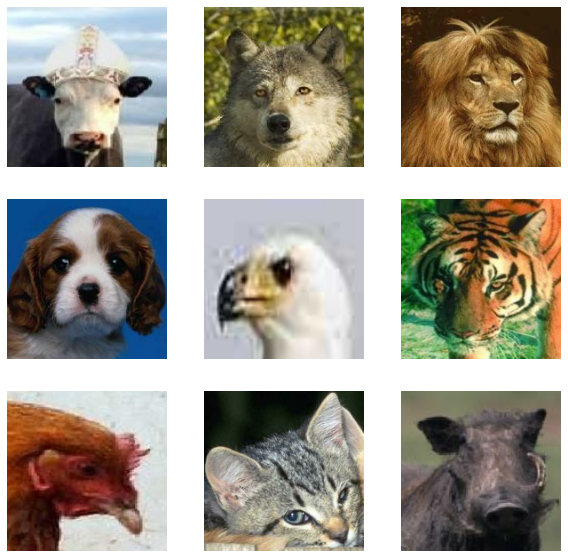

In [14]:
plt.figure(figsize=[10,10])
for image_batch, label_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")



In [15]:
image_batch.shape

TensorShape([64, 180, 180, 3])

## Data Augmentation

Implementing data augmentation using keras.experimental.preprocessing.

Preprocessing the data and applying augmentation inside the model. This will apply preprocessing synchronously with the model execution, and on GPU. Also saves from implementing server-side logic for preprocessing.


In [16]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ], name="data_augmentation")



### Previewing Augmentation

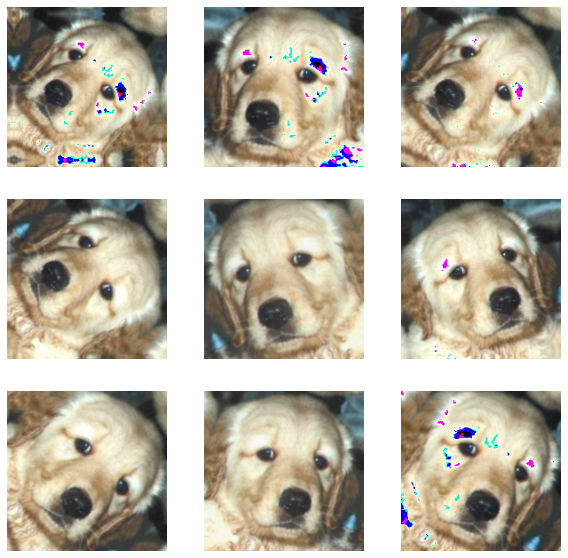

In [17]:
plt.figure(figsize=[10,10])
for image_batch, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(image_batch)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[4].numpy().astype('uint8'))
        plt.axis("off")

In [18]:
from keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

In [19]:
clear_session()
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),#, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(filters=16, kernel_size=3, padding='same', activation='elu'),
    MaxPool2D(), # defaults to (2,2)
    Conv2D(32, 3, padding='same', activation='elu'),
    MaxPool2D(),
    Conv2D(64, 3, padding='same', activation='elu'),
    MaxPool2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='elu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax'),
])

In [20]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        1

Running the model:

In [22]:

history = model.fit(train_ds, validation_data=val_ds, epochs=40, verbose=1)

Epoch 1/40
31/31 [==============================] - 6s 180ms/step - loss: 0.9208 - accuracy: 0.7189 - val_loss: 1.2132 - val_accuracy: 0.6687
Epoch 2/40
31/31 [==============================] - 6s 179ms/step - loss: 0.8447 - accuracy: 0.7412 - val_loss: 1.1568 - val_accuracy: 0.7039
Epoch 3/40
31/31 [==============================] - 6s 177ms/step - loss: 0.8284 - accuracy: 0.7536 - val_loss: 1.2704 - val_accuracy: 0.6687
Epoch 4/40
31/31 [==============================] - 6s 180ms/step - loss: 0.8239 - accuracy: 0.7443 - val_loss: 1.2274 - val_accuracy: 0.6770
Epoch 5/40
31/31 [==============================] - 6s 178ms/step - loss: 0.8182 - accuracy: 0.7433 - val_loss: 1.1893 - val_accuracy: 0.6915
Epoch 6/40
31/31 [==============================] - 6s 178ms/step - loss: 0.7985 - accuracy: 0.7510 - val_loss: 1.0928 - val_accuracy: 0.7205
Epoch 7/40
31/31 [==============================] - 6s 178ms/step - loss: 0.7549 - accuracy: 0.7660 - val_loss: 1.2208 - val_accuracy: 0.6874
Epoch 

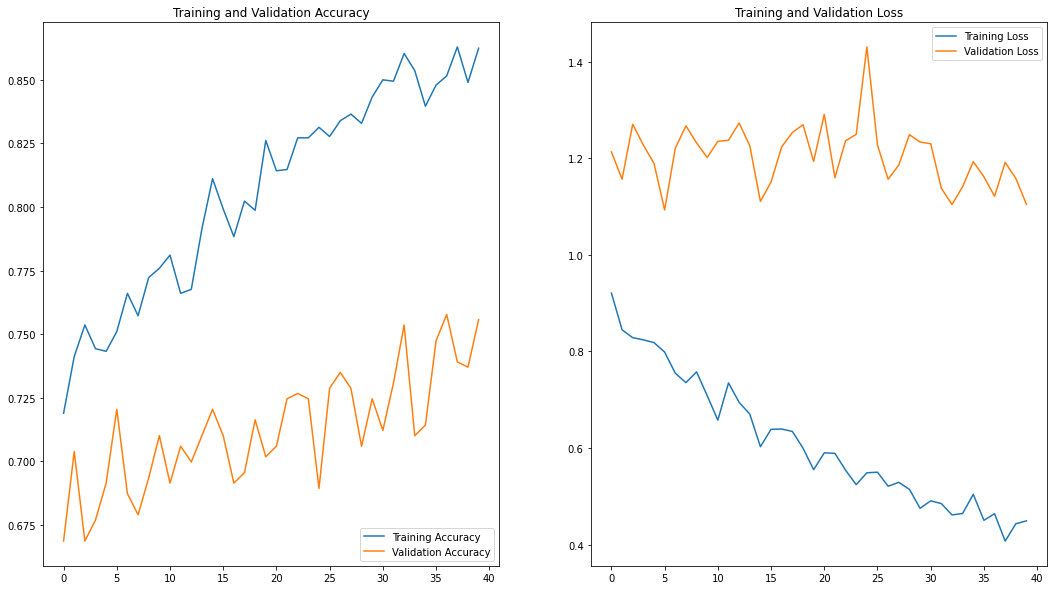

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(E)

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [24]:
from skimage.transform import resize
from google.colab import files
image = files.upload()
print(image.keys())
for k, v in image.items(): pass

Saving cat450a.jpg to cat450a.jpg
dict_keys(['cat450a.jpg'])


(-0.5, 179.5, 179.5, -0.5)

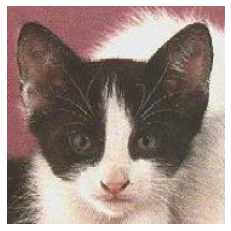

In [25]:
im = imread(k) # 333636a798.jpeg ## fda9a545f5.jpeg
im = resize(im, (IMG_SIZE, IMG_SIZE))
plt.imshow(im)
plt.axis('off')

In [26]:

img = tf.keras.preprocessing.image.load_img(k, target_size=(IMG_SIZE, IMG_SIZE, 3))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)
predictions = model.predict(img_array)

print(predictions)

(1, 180, 180, 3)
[[1.7753062e-04 7.4782223e-01 5.3061350e-11 4.3930922e-07 2.3204977e-08
  9.2965648e-02 1.4144366e-06 4.0143826e-05 2.7331511e-02 7.8303168e-07
  2.6706130e-05 3.5508406e-06 1.3143244e-01 5.2895190e-05 3.1120153e-09
  5.8974160e-06 9.8038618e-07 6.9957816e-05 2.3415943e-08 5.1560423e-06
  6.2712170e-05]]


In [27]:
import numpy as np
print(f"The prediction is '{class_names[np.argmax(predictions)]}' with a score of {np.max(predictions)*100:.2f}%")

The prediction is 'Cat' with a score of 74.78%


In [28]:
print(class_names)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


## GridSearch

In [29]:
clear_session()

In [30]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(n_filters = 8, n_conv_layers=3, drop_ratio=0.2, n_dens_layers=2, n_perc_dens=128, activ_dens='elu', optimizer='adam'):
    model = tf.keras.Sequential()
    model.add(data_augmentation)
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)) #, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for i in range(n_conv_layers):
        nb_filters = (i+1)*n_filters
        model.add(Conv2D(filters=nb_filters, kernel_size=3, padding='same', activation='elu'))
        model.add(MaxPool2D()) # defaults to (2,2)

    model.add(Dropout(drop_ratio))
    model.add(Flatten())
    for i in range(n_dens_layers):
        model.add(Dense(n_perc_dens, activation=activ_dens))
        model.add(Dropout(drop_ratio))
    model.add(Dense(len(class_names), activation="softmax"))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    model.summary()
    return model

model = KerasClassifier(build_fn=create_model)

In [31]:
n_filters = [16]
n_conv_layers = [3, 4]
drop_ratio = [0.1, 0.2]
n_dens_layers = [1, 2]
n_perc_dens = [64, 128]
activ_dens = ['elu'] # ['elu', 'Relu']
optimizer = ['adam']

In [32]:
import numpy as np
X_train = np.empty(shape=(0, IMG_SIZE, IMG_SIZE, 3))
y_train = np.empty(shape=(0, 21))
for elt in train_ds.as_numpy_iterator():
    X_train = np.concatenate((X_train, elt[0]), axis=0)
    y_train = np.concatenate((y_train, elt[1]), axis=0)

In [33]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(epochs = np.array([20]),
                  n_filters = [16, 32],
                  n_conv_layers = [3, 4],
                  drop_ratio = [0.2, 0.3],
                  n_dens_layers = [2],
                  n_perc_dens = [64, 128, 256],
                  activ_dens = ['elu'], # ['elu', 'Relu']
                  optimizer = ['adam'],)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1) ## , n_jobs=-1
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
Epoch 3/20
41/41 [==============================] - 3s 84ms/step - loss: 2.4581 - accuracy: 0.2915
Epoch 4/20
41/41 [==============================] - 3s 83ms/step - loss: 2.2825 - accuracy: 0.2937
Epoch 5/20
41/41 [==============================] - 3s 84ms/step - loss: 2.2069 - accuracy: 0.3403
Epoch 6/20
41/41 [==============================] - 3s 83ms/step - loss: 2.0451 - accuracy: 0.3793
Epoch 7/20
41/41 [==============================] - 3s 83ms/step - loss: 1.8939 - accuracy: 0.4438
Epoch 8/20
41/41 [==============================] - 3s 84ms/step - loss: 1.9237 - accuracy: 0.4059
Epoch 9/20
41/41 [==============================] - 3s 84ms/step - loss: 1.7854 - accuracy: 0.4652
Epoch 10/20
41/41 [==============================] - 3s 83ms/step - loss: 1.6765 - accuracy: 0.4832
Epoch 11/20
41/41 [==============================] - 3s 83ms/step - loss: 1.6810 - accuracy: 0.4778
Epoch 12/20
41/41 [==============================] - 3s 

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 73.0min finished


RuntimeError: ignored

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))